In [1]:
import matplotlib.pyplot as plt
import os
os.chdir('/Users/chichun/Desktop/workspace/AdmixtreGraph2020')
import momi
import sys
sys.path.append('/Users/chichun/Desktop/workspace/AdmixtreGraph2020/scripts')
from admixture_graph import *
from mcmc import *
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from networkx.algorithms.cycles import find_cycle
import logging
logging.basicConfig(level=logging.DEBUG,
                    filename="logs/tmp.log")

In [2]:
g = generate_easy_example_graph()
# nodes
ns = ['RT', 'A', 'B', 'C', 'D',
      '1', '2', '3', '4']

# set event time
ts = [2e5, 0, 0, 0, 0,
      1e5, 5e4, 8e3, 8e3]

ts = [1e5, 0, 0, 0, 0,
      6e4, 1e4, 2e3, 2e3]


t_event = dict()
for i, n in enumerate(ns):
    t_event[n] = ts[i]
g.set_event_time(t_event)

# set event type
types = ['merge'] * 9
types[7] = 'admixture'; types[8] = 'admixture'
types_dict = dict()
for i, n in enumerate(ns):
    types_dict[n] = types[i]
g.set_event_type(types_dict)

# set admixture_proportion
prop = {('3','4'): 0.3}
g.set_admixture_proportion(prop)

# set leaves attribute
demography = g.to_demography(print_events=True)

move from A to B at t = 10000.00
move from B to C at t = 60000.00
move from C to D at t = 100000.00
move from B to C at t = 2000.00 and proportion = 0.3


In [3]:
prefix = 'admixed_4pops.rep'
rep = '1'
sfs = f"data/sfs_{prefix}{rep}.gz"
sfs = momi.Sfs.load(f"data/sfs_{prefix}{rep}.gz")
demography.set_data(sfs)

%matplotlib inline
random.seed(101)
g2, ratio = admixture_edge_proposal(g, print_output=False)
demography2 = g2.to_demography(print_events=True)
demography2.set_data(sfs)

move from B to A at t = 10000.00
move from A to C at t = 60000.00
move from C to D at t = 100000.00
move from A to C at t = 6476.39 and proportion = 0.3


In [4]:
def initialize_mcmc(admixture_graph, sfs, log_acceptance = True, rep = 3000):
    admixture_graph_tmp_holder = admixture_graph.copy()
    # convert networkx admixture graph to a momi demography model
    sfs = momi.Sfs.load(sfs)
    model = admixture_graph.to_demography()
    model.set_data(sfs)
    model_tmp_holder = model.copy()
    trace = {'theta': [], 'loglik': [], 
             'acceptance': [], 'topology': []}
    accept_proposal(
    trace = trace,
    theta = model.get_params(),
    loglik = model.log_likelihood(), 
    topology = admixture_graph.to_newick()
    )
    # metropolis-hasting
    for i in range(rep):
        if i % 20 <= 15:
            admixture_graph_tmp_holder = admixture_graph.copy()
            model_tmp_holder = model.copy()
            # propose new theta
            event_time_proposed_graph, event_time_proposed_demo = event_time_proposal_randomwalk(admixture_graph)
            admixture_graph_tmp_holder.set_event_time(event_time_proposed_graph)
            if admixture_graph_tmp_holder.is_event_order_feasible():
                # if the proposed theta is feasible update it in the holder momi model
                update_theta(model_tmp_holder, event_time_proposed_demo)
                loglik = model_tmp_holder.log_likelihood()
                a = min(np.exp(loglik - trace['loglik'][-1]), 1)
                if np.random.uniform() < a:
                    model = model_tmp_holder.copy()
                    admixture_graph = admixture_graph_tmp_holder.copy()
                    # accept and update current theta
                    accept_proposal(
                        trace = trace,
                        theta = model.get_params(),
                        loglik = loglik, 
                        topology = admixture_graph.to_newick()
                        )
                    result = 'accept'
                else:
                    reject_proposal(trace)
                    result = 'reject'
                if log_acceptance:
                    logging.debug(f'mcmc_{result} time_normalProposal a={a}')
            else:                                                           
                reject_proposal(trace)
                result = 'reject'
                if log_acceptance:
                    logging.debug(f'mcmc_{result} time_normalProposal infeasible')
        elif i % 20 <= 18:
            admixture_graph_tmp_holder = admixture_graph.copy()
            model_tmp_holder = model.copy()
            # propose new admixture proportion
            # To-Do: make sure copies are correct
            admixture_proportion_proposed, q = admixture_proportion_proposal(admixture_graph)
            update_theta(model_tmp_holder, admixture_proportion_proposed)
            loglik = model_tmp_holder.log_likelihood()
            a = min(np.exp(loglik - trace['loglik'][-1] + q), 1)
            if np.random.uniform() < a:
                model = model_tmp_holder.copy()
                admixture_graph = admixture_graph_tmp_holder.copy()
                # accept and update current theta
                accept_proposal(
                    trace = trace,
                    theta = model.get_params(),
                    loglik = loglik, 
                    topology = admixture_graph.to_newick()
                    )
                result = 'accept'
            else:
                reject_proposal(trace)
                result = 'reject'
            if log_acceptance:
                logging.debug(f'mcmc_{result} admixtureFraction_betaProposal a={a}')

        else:
            # propose new admixture position
            admixture_graph_tmp_holder, q = admixture_edge_proposal(admixture_graph)
            #print(admixture_graph_tmp_holder)
            model_tmp_holder = admixture_graph_tmp_holder.to_demography()
            model_tmp_holder.set_data(sfs)
            loglik = model_tmp_holder.log_likelihood()
            a = min(np.exp(loglik - trace['loglik'][-1] + q), 1)
            #print(f'loglik: {loglik}; q: {q}; a: {a}')
            if np.random.uniform() < a:
                model = model_tmp_holder.copy()
                admixture_graph = admixture_graph_tmp_holder.copy()
                # accept and update current theta
                accept_proposal(
                    trace = trace,
                    theta = model.get_params(),
                    loglik = loglik, 
                    topology = admixture_graph.to_newick()
                    )
                result = 'accept'
            else:
                reject_proposal(trace)
                result = 'reject'
            if log_acceptance:
                logging.debug(f'mcmc_{result} admixtureEdge_Proposal a={a}')

    return trace, admixture_graph

In [5]:
prefix = 'admixed_4pops.rep'
rep = '1'
sfs = f"data/sfs_{prefix}{rep}.gz"
trace, ag = initialize_mcmc(admixture_graph = g2, sfs = sfs, log_acceptance = True, rep = 50000)

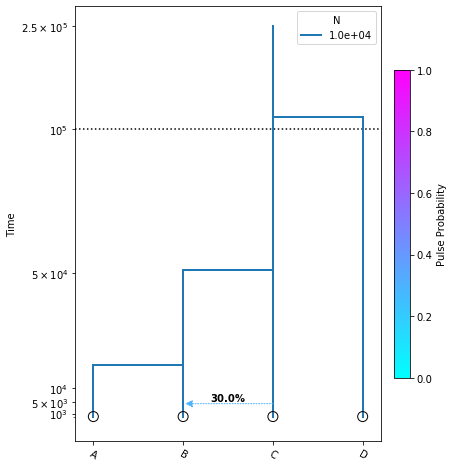

In [23]:
sfs = f"data/sfs_{prefix}{rep}.gz"
sfs = momi.Sfs.load(sfs)
model = ag.to_demography()
model.set_data(sfs)

%matplotlib inline
yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]

fig = momi.DemographyPlot(
    model, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,1))

In [50]:
event_time_proposed_graph, event_time_proposed_demo = event_time_proposal_randomwalk(ag)
admixture_graph_tmp_holder = ag.copy()
admixture_graph_tmp_holder.set_event_time(event_time_proposed_graph)
admixture_graph_tmp_holder.is_event_order_feasible()

True

In [6]:
ll = trace['loglik']
trace_sub = {'theta': [], 'loglik': [], 'acceptance': [], 'topology': []}

for i, l in enumerate(ll):
    if trace['topology'][i]['admixture'] == ['(C)', '(B)']:
        trace_sub['theta'].append(trace['theta'][i])
        trace_sub['loglik'].append(trace['loglik'][i])
        trace_sub['acceptance'].append(trace['acceptance'][i])
        trace_sub['topology'].append(trace['topology'][i])

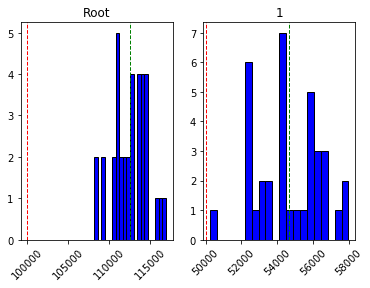

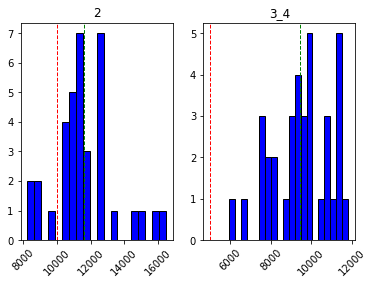

In [8]:
param = []
for i, d in enumerate(trace_sub['theta']):
    param.append(d['RT'])
param = param[1000::20]
plt.subplot(1, 2, 1)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('Root')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(1e5, color='red', linestyle='dashed', linewidth=1)

param = []
for i, d in enumerate(trace_sub['theta']):
    param.append(d['1'])
param = param[1000::20]
plt.subplot(1, 2, 2)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('1')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(5e4, color='red', linestyle='dashed', linewidth=1)
plt.show()

param = []
for i, d in enumerate(trace_sub['theta']):
    param.append(d['2'])
param = param[1000::20]
plt.subplot(1, 2, 1)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('2')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(1e4, color='red', linestyle='dashed', linewidth=1)

param = []
for i, d in enumerate(trace_sub['theta']):
    param.append(d['3_4'])
param = param[1000::20]
plt.subplot(1, 2, 2)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('3_4')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(5e3, color='red', linestyle='dashed', linewidth=1)
plt.show()